In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('creditcard.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [14]:
df.describe().T.style.bar(subset=['mean'], color='#205ff2').background_gradient(subset=['std'], cmap='Reds').background_gradient(subset=['50%'], cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,max
Time,284807.000000,94813.859575,47488.145955,0.000000,54201.500000,84692.000000,139320.500000,172792.000000
V1,284807.000000,0.000000,1.958696,-56.407510,-0.920373,0.018109,1.315642,2.454930
V2,284807.000000,0.000000,1.651309,-72.715728,-0.598550,0.065486,0.803724,22.057729
V3,284807.000000,-0.000000,1.516255,-48.325589,-0.890365,0.179846,1.027196,9.382558
V4,284807.000000,0.000000,1.415869,-5.683171,-0.848640,-0.019847,0.743341,16.875344
V5,284807.000000,-0.000000,1.380247,-113.743307,-0.691597,-0.054336,0.611926,34.801666
V6,284807.000000,0.000000,1.332271,-26.160506,-0.768296,-0.274187,0.398565,73.301626
V7,284807.000000,-0.000000,1.237094,-43.557242,-0.554076,0.040103,0.570436,120.589494
V8,284807.000000,-0.000000,1.194353,-73.216718,-0.208630,0.022358,0.327346,20.007208
V9,284807.000000,-0.000000,1.098632,-13.434066,-0.643098,-0.051429,0.597139,15.594995


In [15]:
corr= df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
Time,1.000000,0.117396,-0.010593,-0.419618,-0.105260,0.173072,-0.063016,0.084714,-0.036949,-0.008660,0.030617,-0.247689,0.124348,-0.065902,-0.098757,-0.183453,0.011903,-0.073297,0.090438,0.028975,-0.050866,0.044736,0.144059,0.051142,-0.016182,-0.233083,-0.041407,-0.005135,-0.009413,-0.010596,-0.012323
V1,0.117396,1.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.227709,-0.101347
V2,-0.010593,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.531409,0.091289
V3,-0.419618,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.210880,-0.192961
V4,-0.105260,-0.000000,-0.000000,0.000000,1.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.098732,0.133447
V5,0.173072,0.000000,0.000000,-0.000000,-0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.386356,-0.094974
V6,-0.063016,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,0.215981,-0.043643
V7,0.084714,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.397311,-0.187257
V8,-0.036949,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,1.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.103079,0.019875
V9,-0.008660,-0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-0.000000,0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,0.000000,-0.044246,-0.097733


In [16]:
df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

we can see there are 284315 non-fraud labels and 492 fraud labels.

### Visualising anomalies

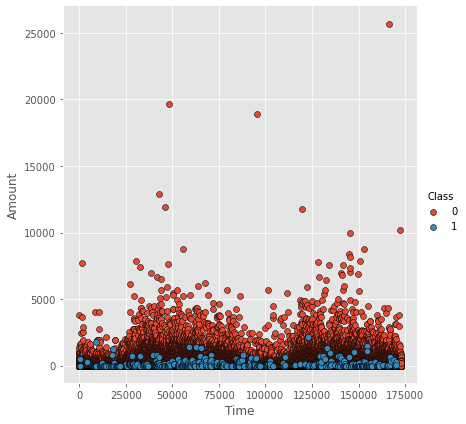

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use("ggplot")
sns.FacetGrid(df, hue="Class", size = 6).map(plt.scatter, "Time", "Amount", edgecolor="k").add_legend()
plt.show()

we can see that the frauds are for amount less than approximately 2000

# Anomaly Detection Using Isolation Forest (Contextual Anomaly)

In [18]:
# Using Unsupervied Learning by hiding the labels(Class column)
datacopy = df.copy()
datacopy.columns

# Selecting all columns except the 'Class' to implement Unsupervised Learning
to_model_cols = datacopy.columns[0:-1]

clf = IsolationForest(n_estimators=10, max_samples='auto', contamination=float(.002), max_features=1, bootstrap=False, n_jobs=-1, verbose=0)
clf.fit(datacopy[to_model_cols])

pred = clf.predict(datacopy[to_model_cols])
datacopy['Class'] = pred
outliers = datacopy.loc[datacopy['Class']==-1]
outlier_index=list(outliers.index)
# Find the number of anomalies and normal points (points classified as "-1" are anomalous)
print(datacopy['Class'].value_counts())

 1    284237
-1       570
Name: Class, dtype: int64


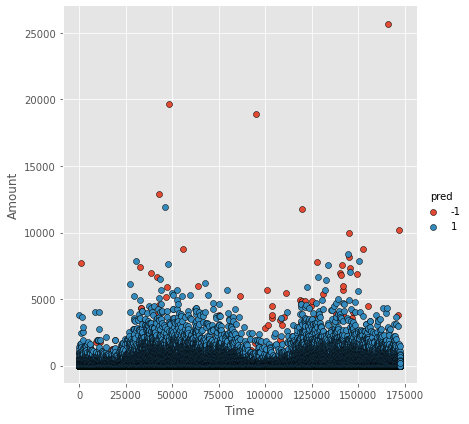

In [19]:
datacopy['pred'] = pred
plt.style.use("ggplot")
sns.FacetGrid(datacopy, hue="pred", size = 6).map(plt.scatter, "Time", "Amount", edgecolor="k").add_legend()
plt.show()

Using Unsupervised learning we can detect 570 frauds whereas the actual frauds are 492.

Lets try out with supervised learning

In [20]:
# Implementing with supervised learning
n_outliers = len(df[df['Class']==1])
outlier_fraction = len(df[df['Class']==1])/float(len(df[df['Class']==0]))

clf = IsolationForest(n_estimators=10, max_samples=len(df.loc[:,df.columns!='Class']), contamination=outlier_fraction, random_state=12345, verbose=0)
X = df.loc[:,df.columns!='Class']
Y = df['Class']
clf.fit(X)
scores_prediction = clf.decision_function(X)
y_pred = clf.predict(X)
y_pred[y_pred == 1] = 0
y_pred[y_pred == -1] = 1
n_errors = (y_pred != Y).sum()

print("No. of Anomalous Points with Isolation Forest :", n_errors)
print("Accuracy Score :", accuracy_score(Y, y_pred))

No. of Anomalous Points with Isolation Forest : 619
Accuracy Score : 0.9978265983631021


With supervised approach we were able to get 619 anomalous points

# Visualizing using PCA

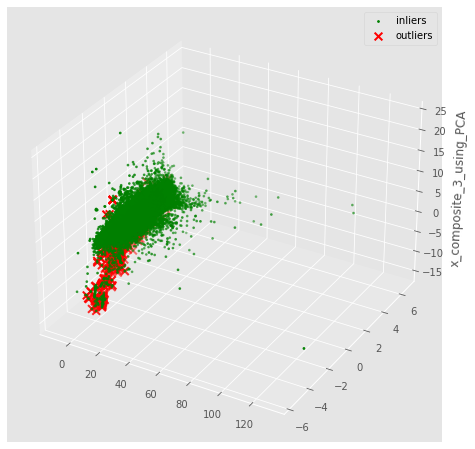

In [21]:
pca = PCA(n_components=3)  #Considered only 3 components to put into 3 dimensions
to_model_cols = df.columns[0:-1]
outliers = df.loc[df['Class']==1]
outlier_index = list(outliers.index)
scaler = StandardScaler()
X = scaler.fit_transform(df[to_model_cols])
X_reduce = pca.fit_transform(X)
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3_using_PCA")
# Plotting compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=3, lw=1, label="inliers",c="green")
# Plot x for the ground truth outliers
ax.scatter(X_reduce[outlier_index,0], X_reduce[outlier_index,1], X_reduce[outlier_index,2], s=60, lw=2, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

# Using t-SNE

In [22]:
standardized_data = StandardScaler().fit_transform(df)
# Taking 100k samples for easy visualization
data = standardized_data[0:100000]
tsne = TSNE(n_components=3, verbose=1, perplexity=40, n_iter=300)
data_reduced = tsne.fit_transform(data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 100000 samples in 0.005s...
[t-SNE] Computed neighbors for 100000 samples in 326.826s...
[t-SNE] Computed conditional probabilities for sample 1000 / 100000
[t-SNE] Computed conditional probabilities for sample 2000 / 100000
[t-SNE] Computed conditional probabilities for sample 3000 / 100000
[t-SNE] Computed conditional probabilities for sample 4000 / 100000
[t-SNE] Computed conditional probabilities for sample 5000 / 100000
[t-SNE] Computed conditional probabilities for sample 6000 / 100000
[t-SNE] Computed conditional probabilities for sample 7000 / 100000
[t-SNE] Computed conditional probabilities for sample 8000 / 100000
[t-SNE] Computed conditional probabilities for sample 9000 / 100000
[t-SNE] Computed conditional probabilities for sample 10000 / 100000
[t-SNE] Computed conditional probabilities for sample 11000 / 100000
[t-SNE] Computed conditional probabilities for sample 12000 / 100000
[t-SNE] Computed conditional prob

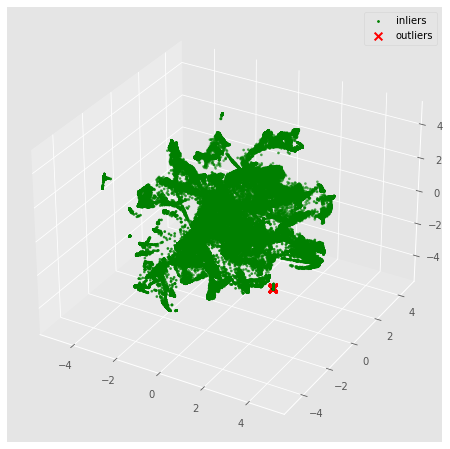

In [23]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
# Plotting the compressed data points
ax.scatter(data_reduced[:, 0], data_reduced[:, 1], zs=data_reduced[:, 2], s=3, lw=1, label="inliers",c="green")
# Plot x(s) for the ground truth outliers
out_index = [i for i in outlier_index if i <= 100000]
ax.scatter(data_reduced[out_index,0], data_reduced[out_index,1], data_reduced[out_index,2], lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()